# [IAPR][iapr]: Lab 2 ‒  Object description


**Group ID:** 22

**Author 1 (sciper):** Alexander Pisarewski(269689)  
**Author 2 (sciper):** Guillaume Champain (261737)   
**Author 3 (sciper):** Adri  (xxxxx)   

**Release date:** 26.03.2021  
**Due date:** 23.04.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

## 0. Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
data_part1 = os.path.join(data_base_path, data_folder, 'part1')
data_part2 = os.path.join(data_base_path, data_folder, 'part2')

tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try:
1. Fourier Descriptors (15pts). 
    1. Implementation (10 pts).
    2. Showing invariance to rotation, translation and scaling (5 pts).
2. Additional method of your choice (5 pts)


**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point. Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

### 1.1 Data visualization

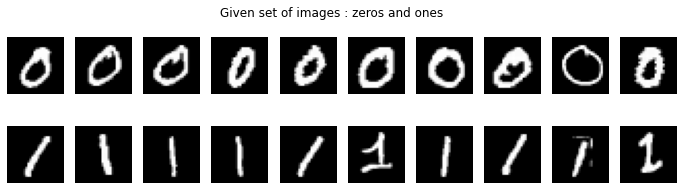

In [2]:
import skimage.io
import matplotlib.pyplot as plt
import cv2
import numpy as np
%matplotlib inline
import itertools
from scipy import special
from scipy import interpolate
import random

def load(path, digit='0'):
    digit_path = os.path.join(path, digit)
    digit_names = [nm for nm in os.listdir(digit_path) if '.png' in nm]  # make sure to only load .png
    digit_names.sort()  # sort file names
    ic = skimage.io.imread_collection([os.path.join(digit_path, nm) for nm in digit_names])
    digit_im = skimage.io.concatenate_images(ic)
    return digit_im, digit_names
                        
#  Load zeros and ones
zeros_im, zeros_names = load(data_part1, digit='0')
ones_im, ones_names = load(data_part1, digit='1')


def plot_img(zeros_im,ones_im,title=None):# Plot images
    fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
    for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
        ax.imshow(im, cmap='gray')
        ax.axis('off')
        #ax.set_title(nm)
    for ax, im, nm in zip(axes[1], ones_im, ones_names):
        ax.imshow(im, cmap='gray')
        ax.axis('off')
       #ax.set_title(nm)
    fig.suptitle(title)
        
plot_img(zeros_im,ones_im,title='Given set of images : zeros and ones')

### 1.2 Fourier descriptors (15 pts)

### Explanation of the Fourier descriptors method implementation

#### Contours
In a first place, the contours of every number has to be found to be able to apply the fourier descriptors method. In order to do so, the OpenCV library is used, preprocessing the images by binarizing the images and returning an array with the consecutive pixels of the contour of the numbers. If scaling happens (explained later on), the contours have to be recalculated in order to find the same amount of pixels as before the transformation : if the image is scaled down, elements are added - if scaled up - contours elements are removed. Contour elements are thus added by taking the mean distance betweem two consecutive points

#### Descriptors
Once the contour is found, the coordinates of the elements of the contour are derived. The fourier transform of the complex contour is calculated.
<br>The <b>first descriptors</b> function saves only a desired number of features of the fourier transform
<br> The <b>fourier descriptors</b> function calls the aforementionned functions and plots a combination of all the chosen features.

### Implementation

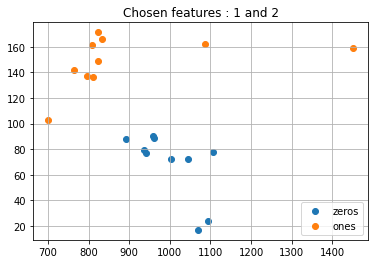

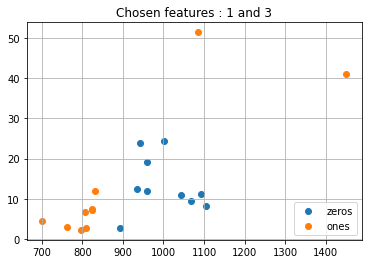

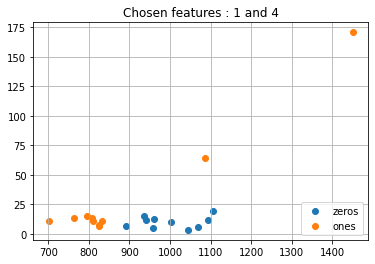

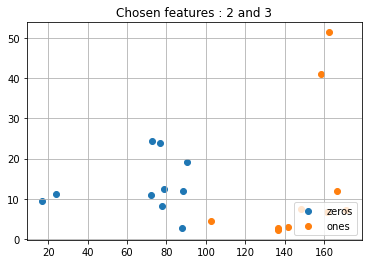

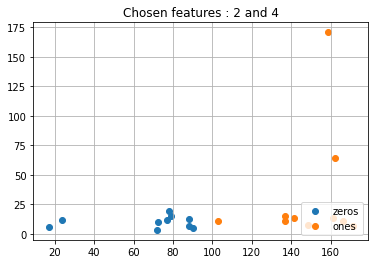

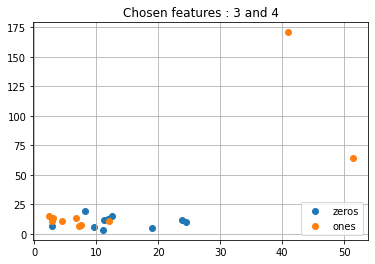

In [15]:
def find_contour(img):

    """ Defines the threshold for the contour and finds the contour into an image.
    Arguments:
        - img : 2-D array (image)

    Returns: 
        - contour_array : Array with contour pixels
        - thresh : Image with contour only

    """   
    ret,thresh = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
    contour, hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    contour_array = contour[0][:, 0, :]
    
    return contour_array, thresh


def interp_contour(ori_contour,contour_array):
    """ Interpolates the contour to add more elements.
    Arguments: 
        - ori_contour : size of the contour of the original image
        - contour_array : Array with pixels of contour

    Returns: 
        - contour_array: New interpolated contour array

    """  
    if contour_array.shape[0]<ori_contour:
        copy_contour=contour_array.copy()
        jj=1
        keepgo=True
        count=0
        while copy_contour.shape[0]<ori_contour and keepgo:
            copy_contour=np.insert(copy_contour,jj,np.array([[(contour_array[count,0]+contour_array[count+1,0])/2],[(contour_array[count,1]+contour_array[count+1,1])/2]]).T,axis=0)            
            if count<(contour_array.shape[0]-2):
                jj+=2
                count+=1
            else:
                keepgo=False

        contour_array = copy_contour.copy()
    elif contour_array.shape[0]>ori_contour:
        copy_contour=contour_array.copy()
        count=1
        while copy_contour.shape[0]<ori_contour:
            copy_contour=np.delete(copy_contour,count,axis=0)
            count+=1
        contour_array = copy_contour.copy()    
            
    return contour_array    

def to_Complex(contour_array,transfo,ori_contour=None):
    """ Calculates the complex coordinates of the contour array and then the fourier transform.
    Arguments:
        - contour_array : Array with pixels of contour
        - transfo : Indicator of transformation or not
        - ori_contour : size of the contour of the original image

    Returns:
        - fourier : Fourier coefficients

    """
    if transfo :
        contour_array=interp_contour(ori_contour,contour_array)
        #print(contour_array.shape)
    
    contour_complex = np.empty(contour_array.shape[:-1], dtype=complex)
    contour_complex.real = contour_array[:, 0]
    contour_complex.imag = contour_array[:, 1]
    fourier = np.fft.fft(contour_complex)

    return fourier

def first_descriptors(fourier,features):
    """ Chooses the number of features to keep in the fourier descriptors
    Arguments:
        - fourier : Fourier coefficients
        - features : Number of features to keep

    Returns: 
        - res : Shortened vector of chosen features

    """
    #features is a vector of the desired features
    res = np.zeros(features.shape)
    count=0
    for ii in features:
        res[count]=np.abs(fourier[ii])
        count+=1
    return res


def fourier_descriptors(ori_contour,number_feat,nb_zeros,nb_ones,images, plot:bool=False, transfo:bool=False):
    """ Combines the previous functions to find the contours from the image and derive the fourier descriptors
    Arguments: 
        - ori_contour : size of the contour of the original image
        - number_feat : Number of features to keep on the fourier vector
        - nb_zeros : number of 0 images
        - nb_ones : number of 1 images,
        - images : Concatenated array of images,
        - plot : Option to plot the descriptors
        - transfo : Indicator of transformation or not

    Returns: 
        - descriptors : Fourier descriptors
        - conts : contours array

    """
    
    poss=int(special.binom((number_feat),2))
    descriptors=np.zeros((nb_zeros+nb_ones,2,poss))
    ii=0
    jj=0
    conts=np.zeros((1,2))
    for a, b in itertools.combinations(range(number_feat), 2):
        for im in images:
            cont,newimg= find_contour(im)
            contimg=np.zeros_like(newimg)
            contimg[cont[:,1],cont[:,0]]=255
            conts=np.append(conts,[cont.shape],axis=0)
            #Show the original and the contour

            if plot: 
                fig, ax = plt.subplots(1, 2, figsize=(12, 7))
                ax[0].imshow(im,cmap='gray')
                ax[1].imshow(contimg, cmap='gray')
                plt.show()
            if transfo:
                fourier = to_Complex(cont,transfo,ori_contour[ii,0])
            else:
                fourier = to_Complex(cont,transfo)

            feat=np.array([a,b])
            descriptors[ii,:,jj]=first_descriptors(fourier,feat)

            ii+=1
        ii=0
        jj+=1
        print('\n\n\n')
    conts=np.delete(conts,0,0)
    return descriptors, conts


images = np.concatenate((zeros_im,ones_im))
nb_zeros=zeros_im.shape[0]
nb_ones=ones_im.shape[0]
number_feat=4
init_contour=np.zeros((1,2))
descriptors,original_contour= fourier_descriptors(init_contour,number_feat,nb_zeros,nb_ones,images, plot=False, transfo=False)

kk=0

for a, b in itertools.combinations(range(number_feat), 2):
    fig, ax = plt.subplots(1)
    ax.scatter(descriptors[0:nb_zeros,0,kk],descriptors[0:nb_zeros,1,kk],label='zeros')
    ax.scatter(descriptors[nb_zeros:,0,kk],descriptors[nb_zeros:,1,kk],label='ones')
    ax.grid()
    plt.title('Chosen features : {} and {}'.format(a+1,b+1))
    leg=ax.legend(loc='lower right')
    kk+=1

###  1.3 Invariance to Rotation, Translation and Scaling

### Implementation details

The chosen approach in order to verify the invariance of the fourier with respect to a random transformation is to apply a random transformation to the image and to check weather the fourier descriptors vary or not. As the image is of quite poor resolution one could imagine that changing it might induce some variations of the contour and thus, different fourier descriptors. However the grouping shall remain similar and the two classes shall remain seperable. 

This transformation is chosen as follows:

<ol>
<li>A random translation in x and y with a maximal amplitude of 7 pixels. This amplitude has been chosen as it allows the digit to stay in the frame of the image. </li>
<li>A random rotation ranging between 0$^\circ$ and 360 $^\circ$</li>
<li>A random scaling factor in the range of 0.5 and 1.5. These bounds have been chosen such that the contour is still visible enough for decent detection.</li>
</ol>

First of all, the invariance of the method has been tested on each transformation individually. The reader can find the function that allows the transformation of a greyscale images.


In [4]:
def transformation(img,translation:bool=False,rotation:bool=False,scale:bool=False):
    
    """Returns a transformed version of the orginial ones and zeros provided as input
    
    Arguments: 
        im: 28x28 greyscale images
        translation: boolean
        rotation: boolean
        scale: boolean
        
    Returns: 
        img_dst: transformed 28x28 greyscale image
         
    """
    img_dst=np.zeros(img.shape)
    rows,cols = img[0,:,:].shape
    trans=5

    for i in range(0,len(zeros_im)):
        n1,n2=0,0
        sc=1
        rot=0
        if translation:
            n1 = random.randint(-trans,trans)
            n2 = random.randint(-trans,trans)
                       
        if rotation:
            rot = 360*random.random()
                      
        if scale:
            sc =0.8*random.random()+0.6
        
        M_t = np.float32([[1,0,n1],[0,1,n2]]) #translation matric
        M_rot_sc = cv2.getRotationMatrix2D((cols/2,rows/2),rot,sc) #rotation and scaling matrix
        img_dst[i,:,:] = cv2.warpAffine(img[i,:,:],M_t,(cols,rows))   # translation transformation
        img_dst[i,:,:] = cv2.warpAffine(img_dst[i,:,:],M_rot_sc,(cols,rows)) #rotation and scaling transforamtion


    img_dst = img_dst.astype(np.uint8)
    
    return img_dst
  

### A) Translation

Below are shown the descriptors of the original and the translated image and one can notice that the graphs displaying the very first fourier descriptor change with the transformation (graphs with *feature 1*). This makes sense as the first fourier descriptor encapsulates the information of the position of the contour in the image. 
<br>Oberving the graphs displaying higher order features, no consequent variation is observed. The minor changes that appear are due to a too large translation of the image which makes it go a little out of the frame and therefore change it's contour.
 
 

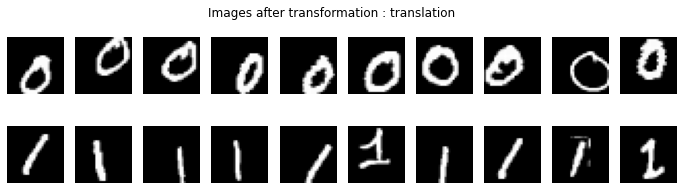

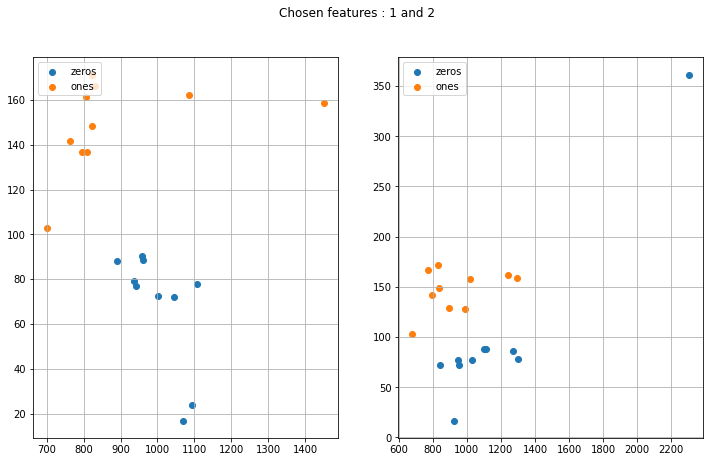

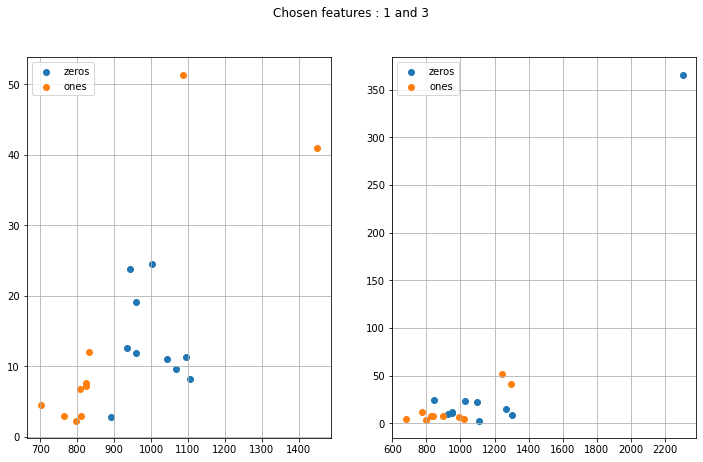

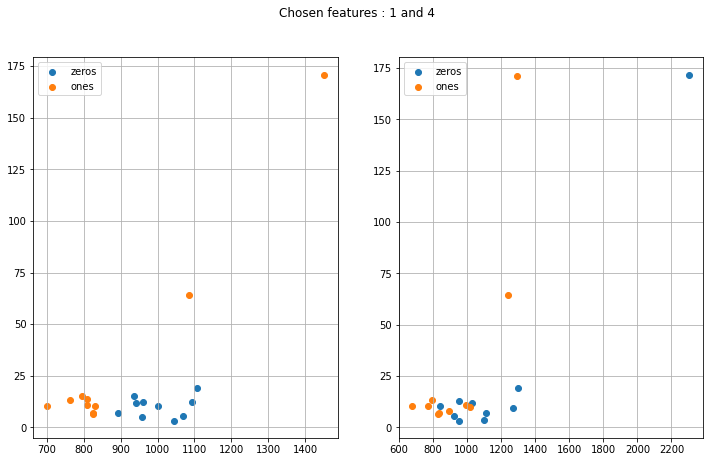

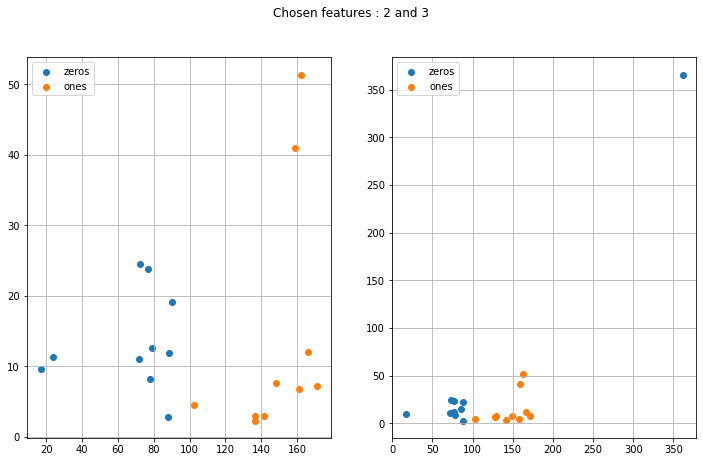

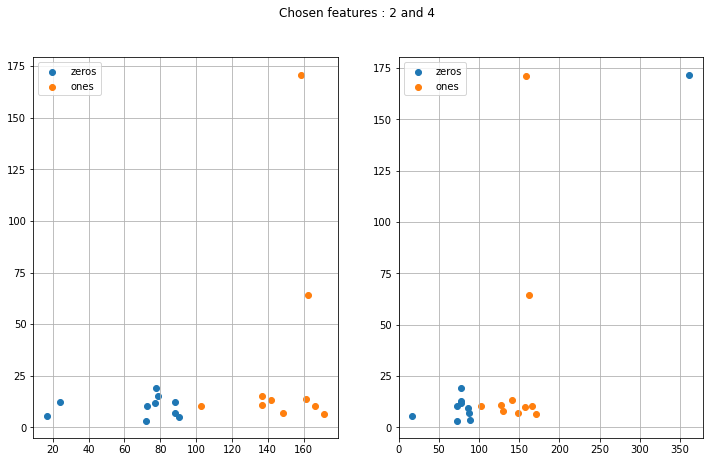

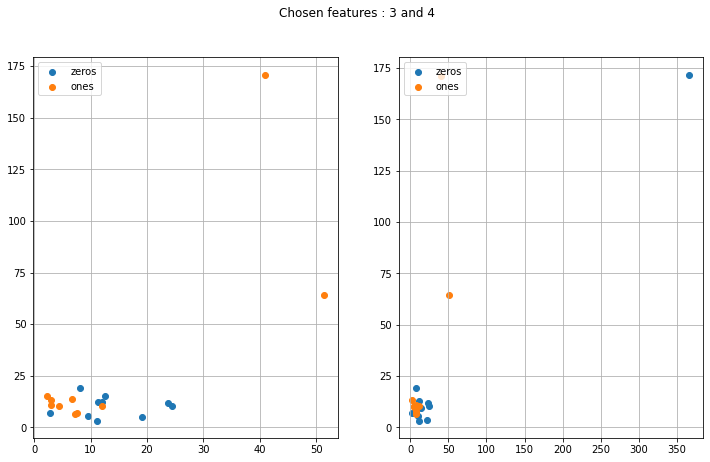

In [5]:
ones_im_dst=transformation(ones_im,translation=True,rotation=False,scale=False)
zeros_im_dst=transformation(zeros_im,translation=True,rotation=False,scale=False)
images_dst = np.concatenate((zeros_im_dst,ones_im_dst))
nb_zeros=zeros_im.shape[0]
nb_ones=ones_im.shape[0]

plot_img(zeros_im_dst,ones_im_dst,title='Images after transformation : translation')

descriptors1,new_cont= fourier_descriptors(original_contour,number_feat,nb_zeros,nb_ones,images_dst,plot=False,transfo=True)

kk=0
for a, b in itertools.combinations(range(number_feat), 2):
    fig, ax = plt.subplots(1,2,figsize=(12, 7))
    
    ax[0].scatter(descriptors[0:nb_zeros,0,kk],descriptors[0:nb_zeros,1,kk],label='zeros')
    ax[0].scatter(descriptors[nb_zeros:,0,kk],descriptors[nb_zeros:,1,kk],label='ones')
    
    ax[1].scatter(descriptors1[0:nb_zeros,0,kk],descriptors1[0:nb_zeros,1,kk],label='zeros')
    ax[1].scatter(descriptors1[nb_zeros:,0,kk],descriptors1[nb_zeros:,1,kk],label='ones')
    
    leg=ax[1].legend(loc='upper left')
    leg=ax[0].legend(loc='upper left')
    ax[0].grid()
    ax[1].grid()
    plt.suptitle('Chosen features : {} and {}'.format(a+1,b+1))
    kk+=1

### B) Rotation & Discussion

Rotation should not impact the amplitude of the descriptors as it only affects the phase. Thus the graphs should remain the same after transformation. 
The fourier descriptors before and after the rotation of the image  are shown below. 
The overall repartition of the points remain similar after the rotation, however the amplitude of these descriptors vary. This variation can be explained through the weak resolution of the images which affects the contour computation and thus the derivation of the fourier descriptors. 

It is important to notice that the two classes stay separable with respect to the two first descriptors, which is essential for correct classification

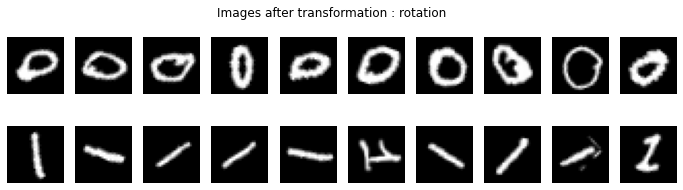

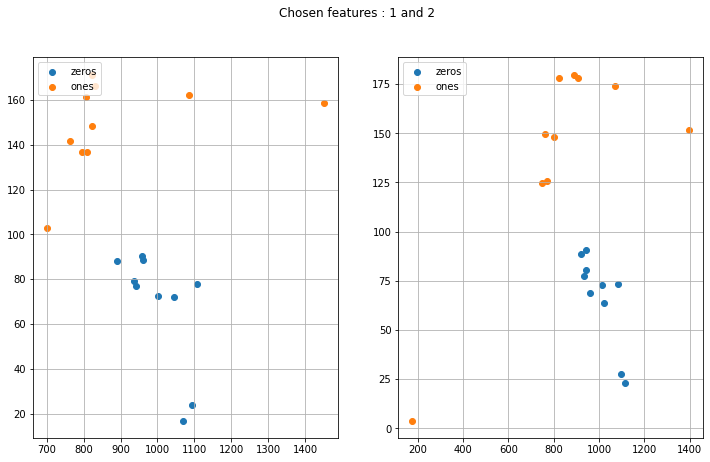

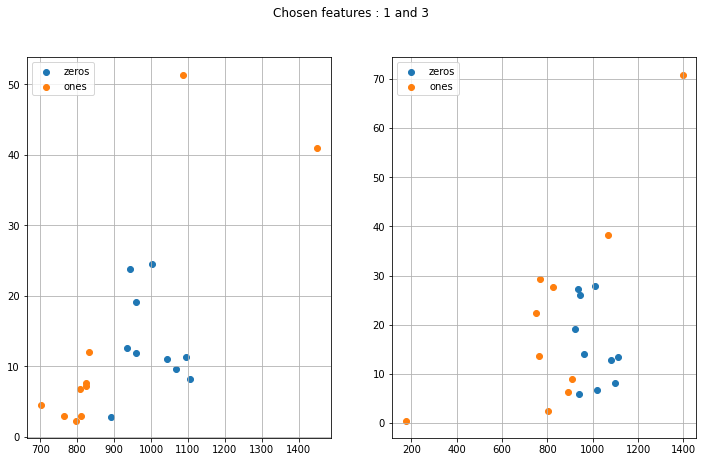

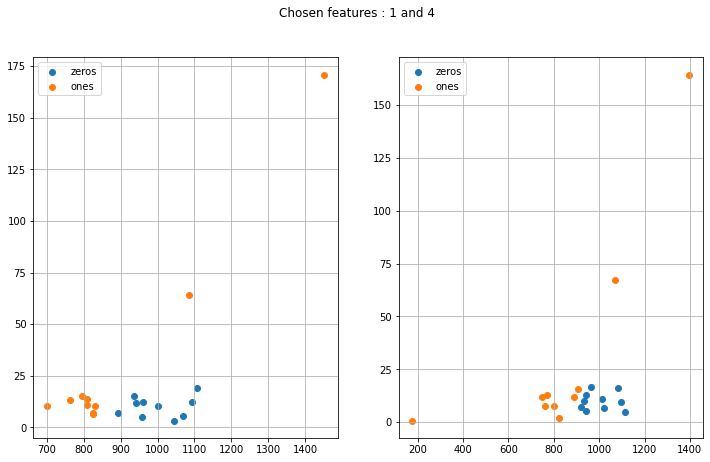

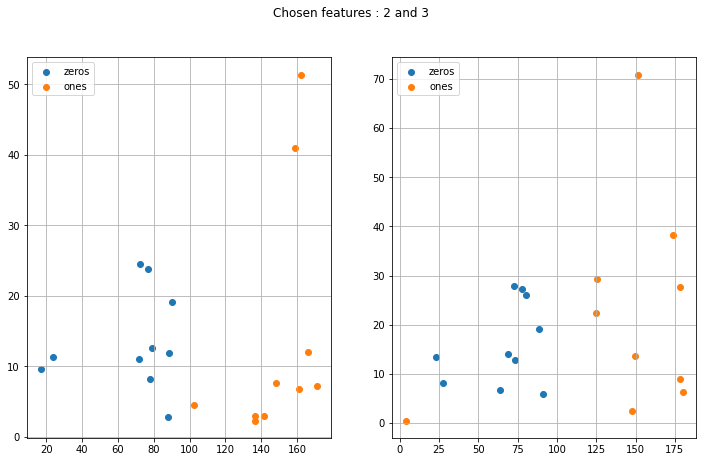

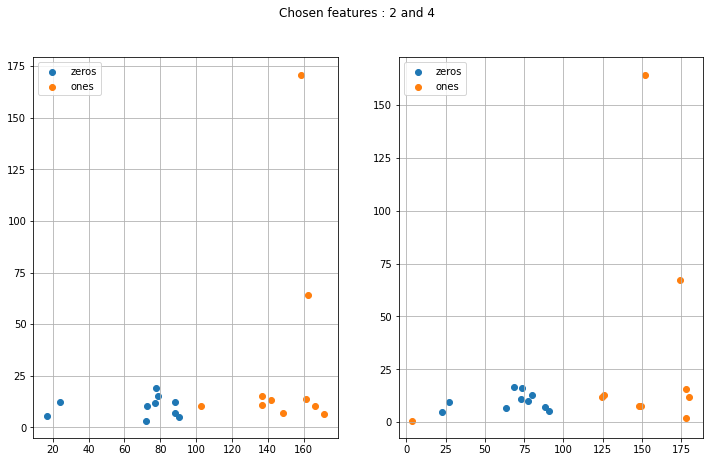

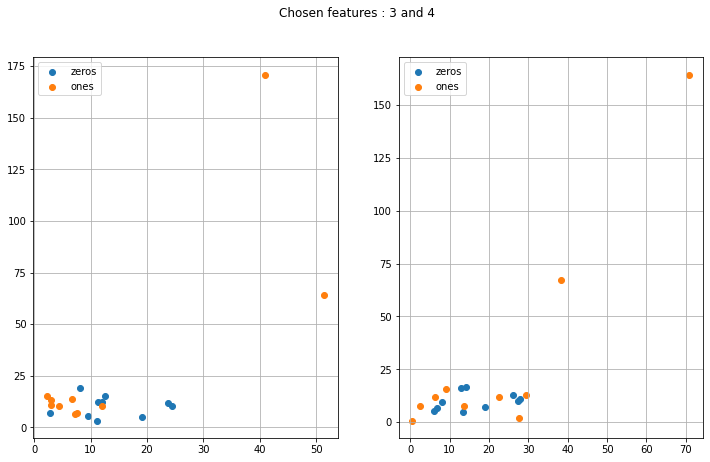

In [6]:
ones_im_dst=transformation(ones_im,translation=False,rotation=True,scale=False)
zeros_im_dst=transformation(zeros_im,translation=False,rotation=True,scale=False)
images_dst = np.concatenate((zeros_im_dst,ones_im_dst))
nb_zeros=zeros_im.shape[0]
nb_ones=ones_im.shape[0]

plot_img(zeros_im_dst,ones_im_dst,title='Images after transformation : rotation')

descriptors1,new_cont= fourier_descriptors(original_contour,number_feat,nb_zeros,nb_ones,images_dst,plot=False,transfo=True)

kk=0
for a, b in itertools.combinations(range(number_feat), 2):
    fig, ax = plt.subplots(1,2,figsize=(12, 7))
    
    ax[0].scatter(descriptors[0:nb_zeros,0,kk],descriptors[0:nb_zeros,1,kk],label='zeros')
    ax[0].scatter(descriptors[nb_zeros:,0,kk],descriptors[nb_zeros:,1,kk],label='ones')
    
    ax[1].scatter(descriptors1[0:nb_zeros,0,kk],descriptors1[0:nb_zeros,1,kk],label='zeros')
    ax[1].scatter(descriptors1[nb_zeros:,0,kk],descriptors1[nb_zeros:,1,kk],label='ones')
    
    leg=ax[1].legend(loc='upper left')
    leg=ax[0].legend(loc='upper left')
    ax[0].grid()
    ax[1].grid()
    plt.suptitle('Chosen features : {} and {}'.format(a+1,b+1))
    kk+=1

### B) Scaling

Below are shown the descriptors of the original and the scled image. Here a noticable difference is present. This might be induced by the  difference of the contour detection which then results in large difference of the amplitude of the  fourier descriptors. 

However, despite these differences,depending on the degree of scaling, one can notice a similar grouping of the points which allow to cluster the points even after this transformation. 

Extreme cases: If the scaling is too small, the contour is not detected at all since the figure becomes too small.  On the other side if the scaling is too large, the contour might not fit in the image and is not closed which also does not allow a proper detection ot the contour. 

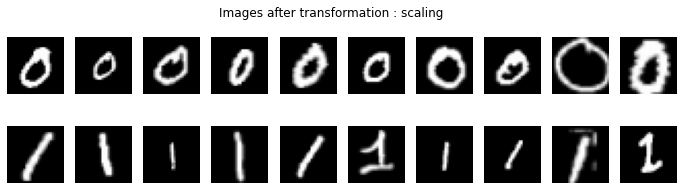

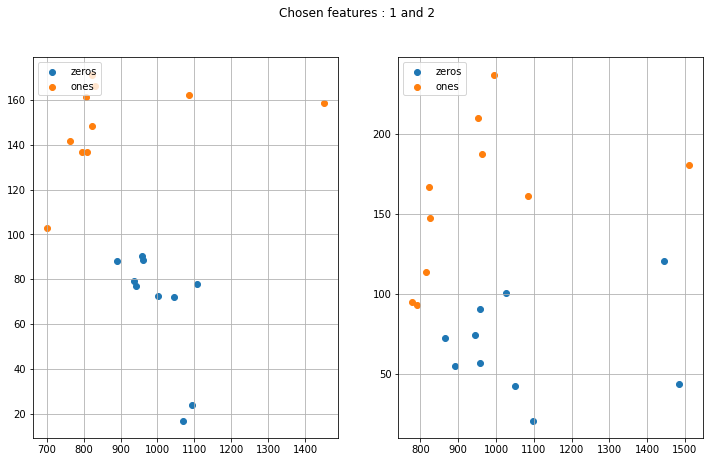

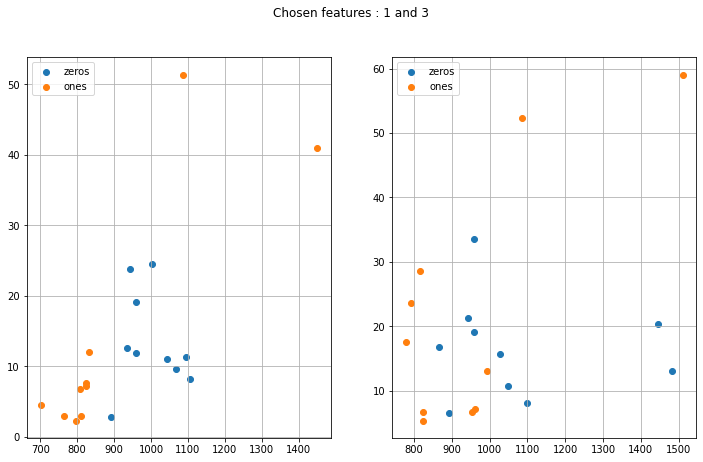

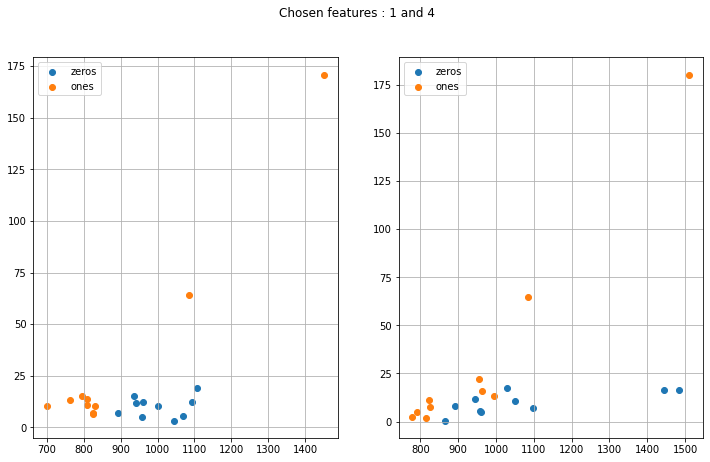

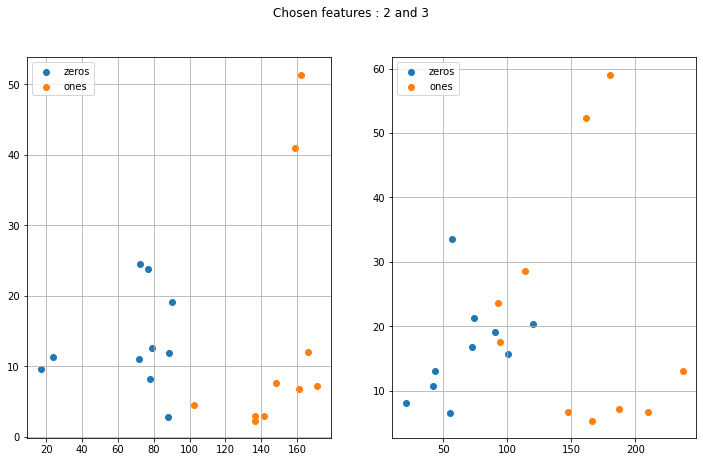

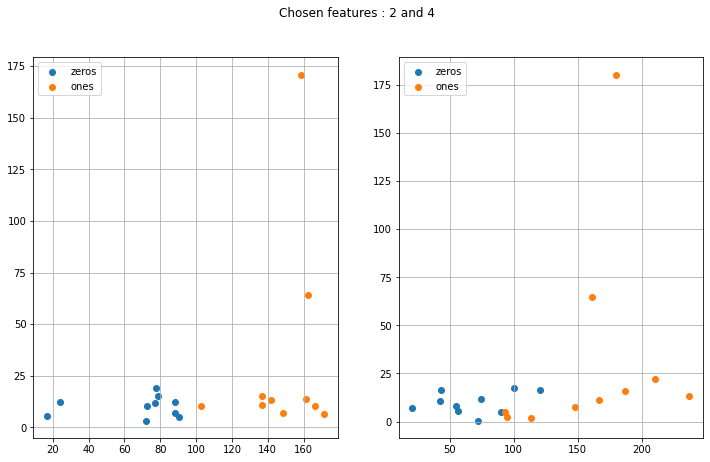

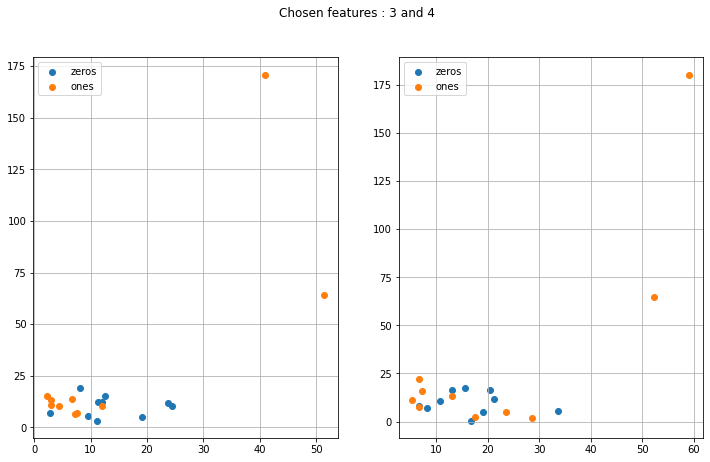

In [7]:
ones_im_dst=transformation(ones_im,translation=False,rotation=False,scale=True)
zeros_im_dst=transformation(zeros_im,translation=False,rotation=False,scale=True)
images_dst = np.concatenate((zeros_im_dst,ones_im_dst))
nb_zeros=zeros_im.shape[0]
nb_ones=ones_im.shape[0]


plot_img(zeros_im_dst,ones_im_dst,title='Images after transformation : scaling')

descriptors1,new_cont= fourier_descriptors(original_contour,number_feat,nb_zeros,nb_ones,images_dst,plot=False,transfo=True)

kk=0
for a, b in itertools.combinations(range(number_feat), 2):
    fig, ax = plt.subplots(1,2,figsize=(12, 7))
    
    ax[0].scatter(descriptors[0:nb_zeros,0,kk],descriptors[0:nb_zeros,1,kk],label='zeros')
    ax[0].scatter(descriptors[nb_zeros:,0,kk],descriptors[nb_zeros:,1,kk],label='ones')
    
    ax[1].scatter(descriptors1[0:nb_zeros,0,kk],descriptors1[0:nb_zeros,1,kk],label='zeros')
    ax[1].scatter(descriptors1[nb_zeros:,0,kk ],descriptors1[nb_zeros:,1,kk],label='ones')
    
    leg=ax[1].legend(loc='upper left')
    leg=ax[0].legend(loc='upper left')
    ax[0].grid()
    ax[1].grid()
    plt.suptitle('Chosen features : {} and {}'.format(a+1,b+1))
    kk+=1

### 1.3 Additional method (5 pts)

### Explanation of the additional method : Freeman code built + Edition distance comparison

#### Freeman chain code 

We designed an algorithm in order to create a string chain of connected pixels position from specific contours. The purpose is to link the position of the next pixel relative to the previous ones thanks 8 direction numbered from 0 to 7.
In our "freeman_chain_making" function we start by filtered the argument image, because in some situation the contours give by the scikit image librairy are not connected among them. The "find_coutours " function returns float values points, therefore we convert them in integer and associate them to original image pixels. Afterwards, we just check in which direction is the next contours point and append the matching value inside a string chain.

#### Wagner-Fisher algorithm

To compute the edition distance and create a plot comparison we used the Wagner-Fisher algorithm. The latter returns the minimum number of elementary operations (deletes, inserts, substitutes) necessary to convert a string chain into another one. We set all elementary operations with the same cost, but it is customizable in the function.
At the begining, we take into account that we can obtain an empty chain by deleted all original characters or inserts all the desired characters. Then, if the character from chain 1 is the same as chain 2 the cost is 0 otherwise we add the minimum cost between the three elementary operations to our edition distance variable. Finally, the function "dist_wagner_fischer" returns the right edition distance.

#### Plot description

In order to choose our right features (2 images among a digit 1 and a digit 0), we will plot a bunch of differents features combination and select the best in our opinion. First we will store in a list the edition distance of all others images with the 2 selected features. The x-axis represents the edition distance with the feature digit 0 and the y axis with the feature 1. 
We can clearly see two different area of the scatter final plot. The blue one coincides with zeros (low x values) and the orange one with ones ( low y values). But we can note some images we see high x and y values it could be because 1 digits experience differents shapes. But for the zeros cluster it seems well gathered.


In [8]:
#Freeman code 
from skimage.morphology import skeletonize
from skimage.filters import gaussian
from skimage import measure
import numpy as np

# Create Freeman direction value array
zip_freeman_idx ={(1, 0): 0,  (1, 1): 1, (0, 1): 2, (-1, 1): 3, (-1, 0): 4, (-1, -1): 5, (0, -1): 6,(1, -1): 7}

def freeman_chain_making(im) :
    filtered_im=gaussian(im,0.5) #necessary to have connected contours 
    contours_im= max(measure.find_contours(filtered_im,0.2),key=len) #get contours detection
    round_contours = []
    for i in contours_im :
        new = [int(round(i[0],0)),int(round(i[1],0))]
        if new not in round_contours :
            round_contours.append(new)
    length_contours = len(round_contours) -1
    round_contours.append(round_contours[0])
    next_index=round_contours[0]
    chain = []
    k=0
    while k < length_contours :
        #print(k)
        for i in [-1,0,1] :
            for j in [-1,0,1] :
                if i == 0 and j==0 :
                    pass
                else :
                    if [next_index[0]+i,next_index[1]+j]==round_contours[k+1] :
                        next_index = [next_index[0]+i,next_index[1]+j]
                        chain.append(zip_freeman_idx[i,j])
                        k+=1
                        break                    
    chain_code = ''.join(map(str, chain))
    return chain_code


#Edition distance thanks to Wagner-Fisher algorithm
def dist_wagner_fischer(chain_1, chain_2, costs=(1, 1, 1)):

    rows = len(chain_1)+1
    cols = len(chain_2)+1
    deletes, inserts, substitutes = costs
    
    dist = [[0 for x in range(cols)] for x in range(rows)]

    # source prefixes can be transformed into empty strings 
    # by deletions:
    for row in range(1, rows):
        dist[row][0] = row * deletes

    # target prefixes can be created from an empty source string
    # by inserting the characters
    for col in range(1, cols):
        dist[0][col] = col * inserts
        
    for col in range(1, cols):
        for row in range(1, rows):
            if chain_1[row-1] == chain_2[col-1]:
                cost = 0
            else:
                cost = substitutes
            dist[row][col] = min(dist[row-1][col] + deletes,
                                 dist[row][col-1] + inserts,
                                 dist[row-1][col-1] + cost) # substitution
    
    return dist[row][col]


def extract_comparison_features(num_feat_zero,num_feat_one) :
    #Index list for zeros/ones images
    list_zeros =[i for i in range(10)]
    list_ones =[i for i in range(10)]
    
    #Delete the selected features from images to process
    list_zeros.remove(num_feat_zero)
    list_ones.remove(num_feat_zero)

    #Create reference Freeman chain for the 2 features
    chain_feature_1 = freeman_chain_making(zeros_im[num_feat_zero])
    chain_feature_2 = freeman_chain_making(ones_im[num_feat_one])
    
    #Comparison edition distance of zeros images with the 2 features
    x_0 = []
    y_0 = []
    for i in list_zeros :
        freeman_chain = freeman_chain_making(zeros_im[i])
        #print(freeman_chain)
        x_0.append(dist_wagner_fischer(freeman_chain, chain_feature_1))
        y_0.append(dist_wagner_fischer(freeman_chain, chain_feature_2))

    #Comparison edition distance of ones images with the 2 features
    x_1 = []
    y_1 = []
    for i in list_ones :
        freeman_chain = freeman_chain_making(ones_im[i])
        x_1.append(dist_wagner_fischer(freeman_chain, chain_feature_1))
        y_1.append(dist_wagner_fischer(freeman_chain, chain_feature_2))  
    
    results_ED=[x_0,y_0,x_1,y_1]
    return results_ED

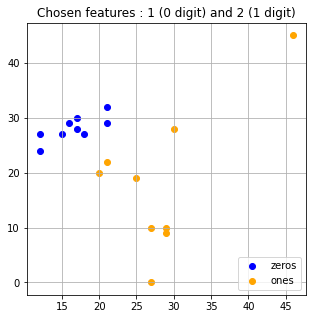

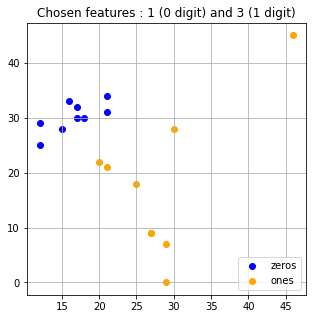

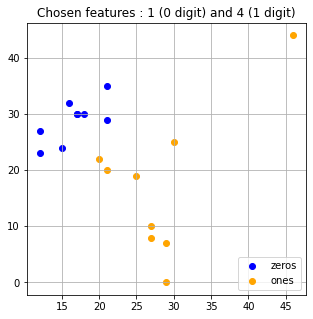

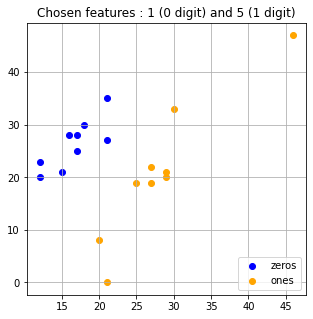

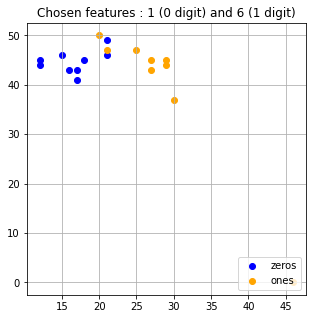

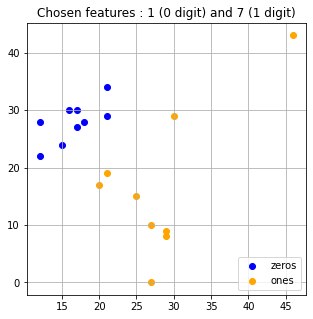

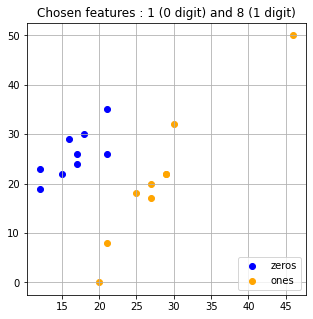

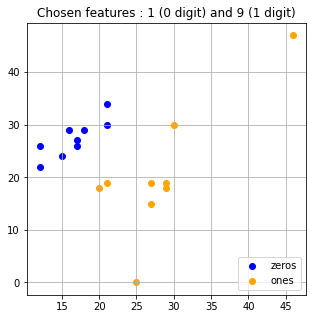

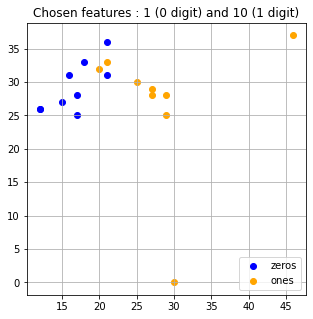

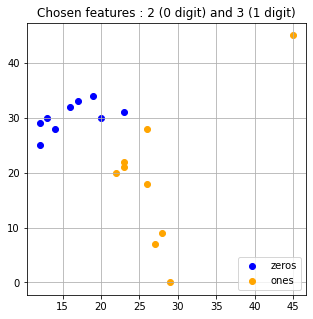

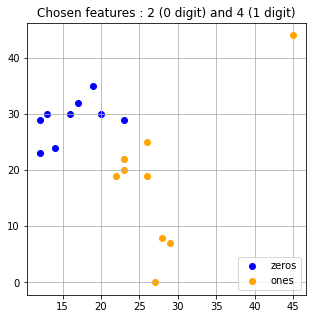

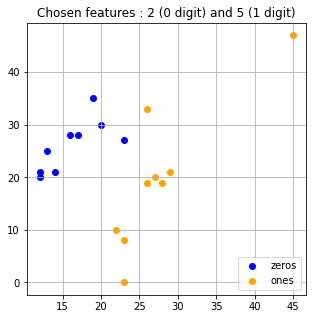

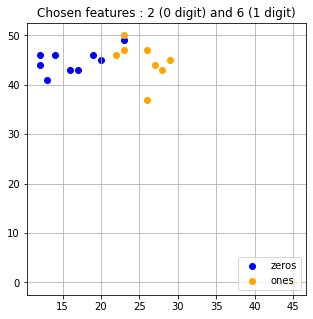

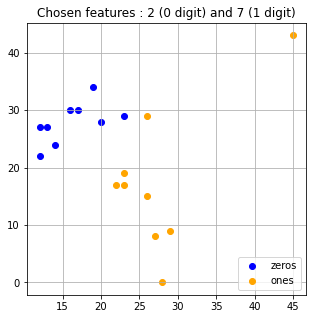

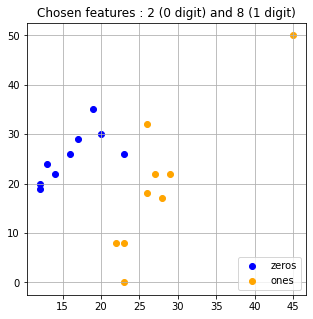

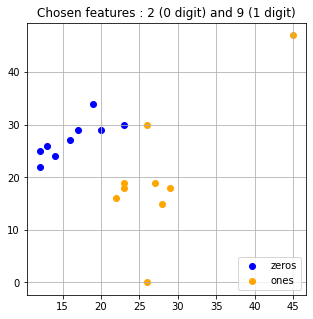

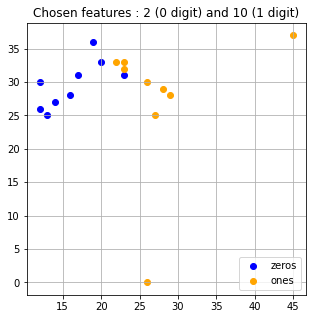

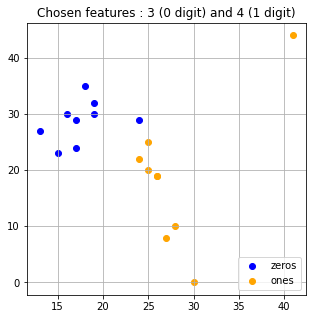

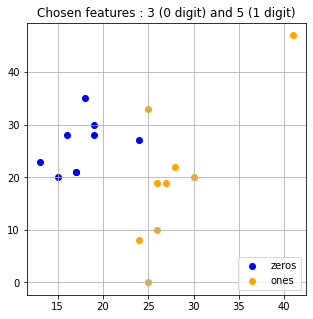

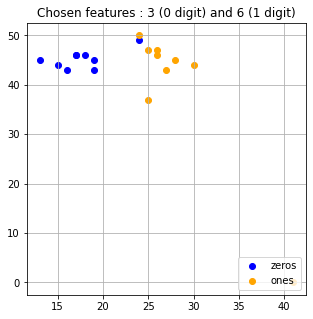

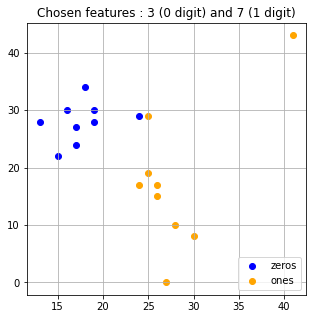

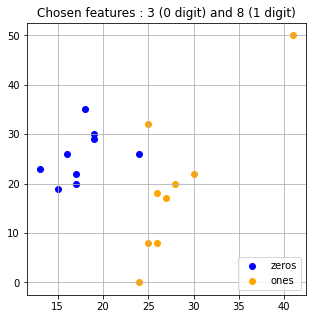

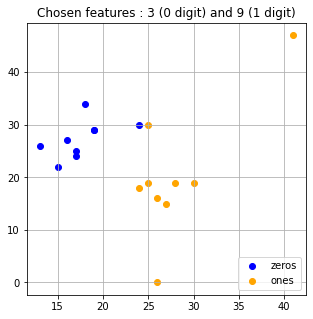

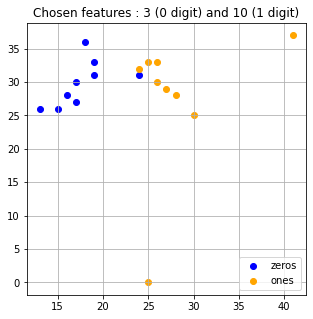

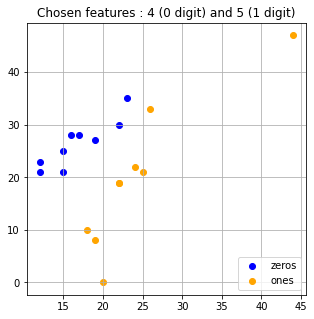

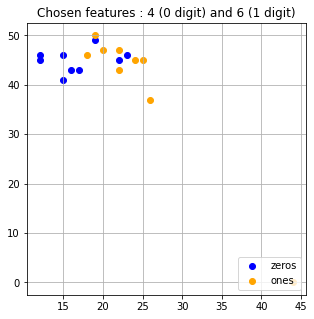

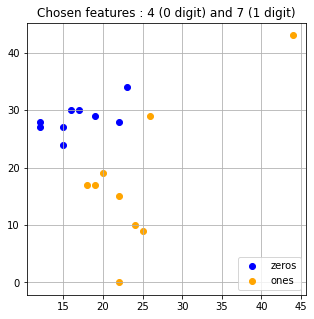

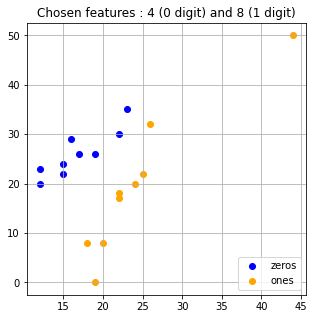

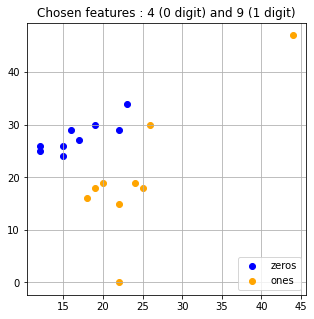

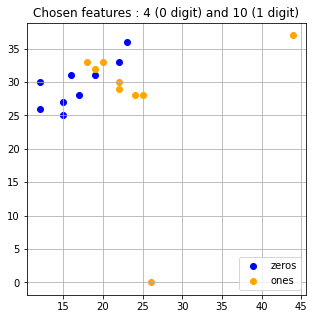

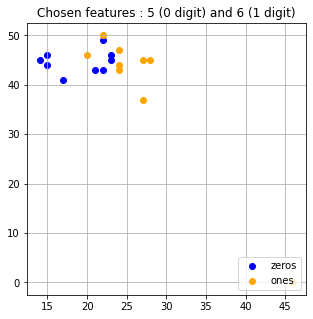

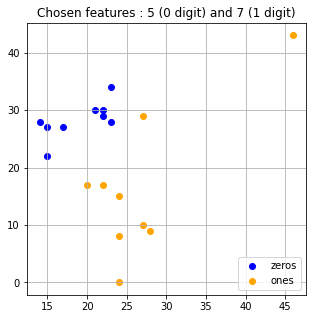

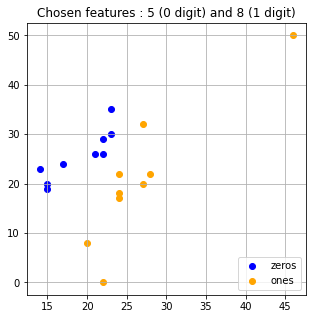

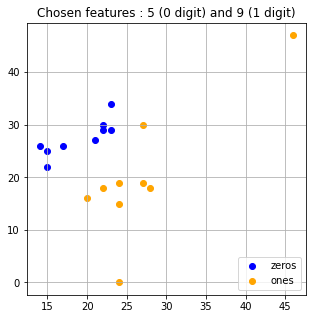

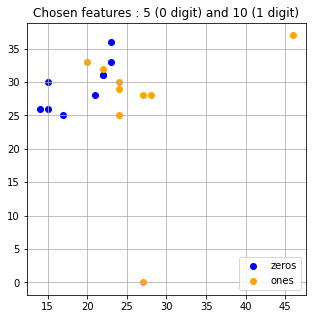

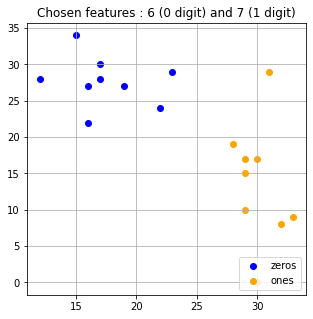

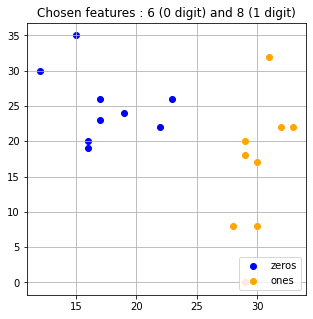

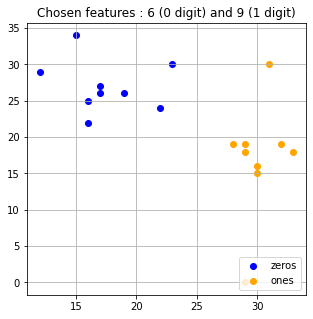

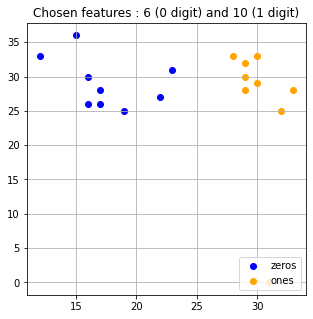

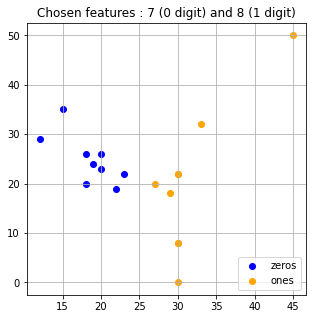

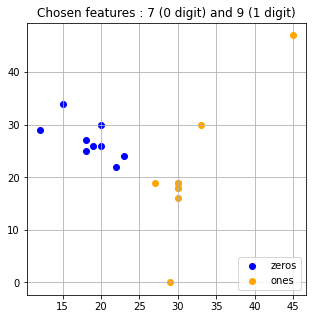

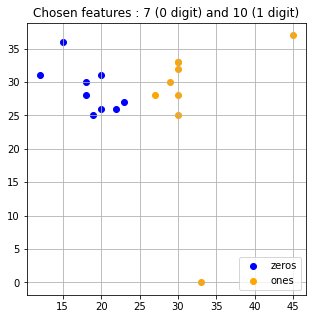

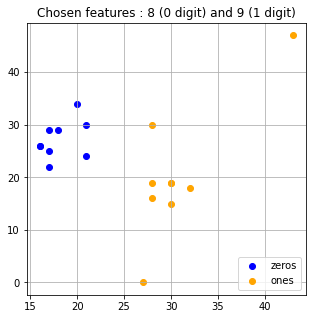

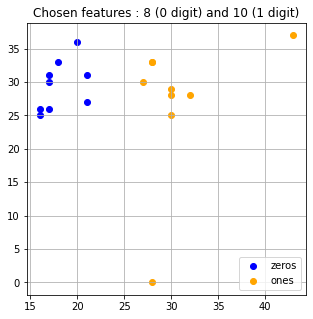

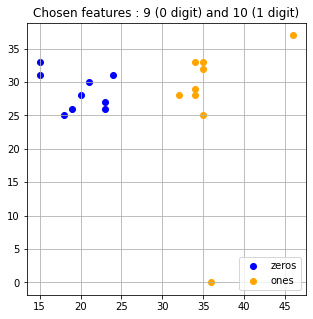

In [9]:
import itertools
# Plot some features combination to see the best cluster option
for num_feat_zero, num_feat_one in itertools.combinations(range(10), 2):
    results_ED = extract_comparison_features(num_feat_zero, num_feat_one)
    fig, ax = plt.subplots(1,1,figsize=(5, 5))
    ax.scatter(results_ED[0],results_ED[1],label='zeros',color='blue')
    ax.scatter(results_ED[2],results_ED[3],label='ones',color='orange')
    ax.grid()
    plt.title('Chosen features : {} (0 digit) and {} (1 digit)'.format(num_feat_zero+1,num_feat_one+1))
    plt.rcParams.update({'figure.max_open_warning': 0})
    leg=ax.legend(loc='lower right')

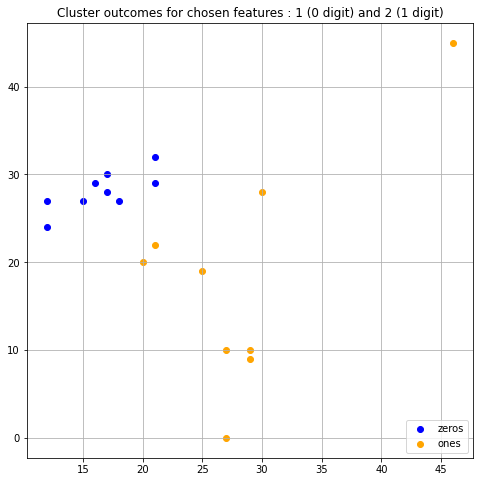

In [10]:
#Index list for zeros/ones images
list_zeros =[i for i in range(10)]
list_ones =[i for i in range(10)]

#Best features choice number regarding previous graphics
num_feat_zero = 0
num_feat_one = 1

results_best_ED = extract_comparison_features(num_feat_zero, num_feat_one)
#Display the edition distance of zeros and ones 
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.scatter(results_best_ED[0],results_best_ED[1],label='zeros',color='blue')
ax.scatter(results_best_ED[2],results_best_ED[3],label='ones',color='orange')
ax.grid()
plt.title('Cluster outcomes for chosen features : {} (0 digit) and {} (1 digit)'.format(num_feat_zero+1,num_feat_one+1))
leg=ax.legend(loc='lower right')

---
## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

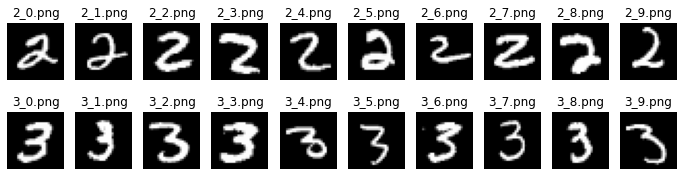

In [11]:
#  Load twos and threes
twos_im, twos_names = load(data_part2, digit='2')
threes_im, threes_names = load(data_part2, digit='3')

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Fourier descriptors - 4 digits (10 pts)

### Implementation
The process for the implementation is the same as for the first part of this assignment : the contours are found, the fourier transform derived and a number of features is saved to be plotted

(40, 2, 10)


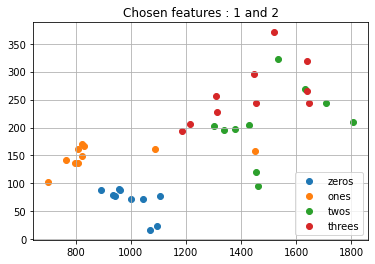

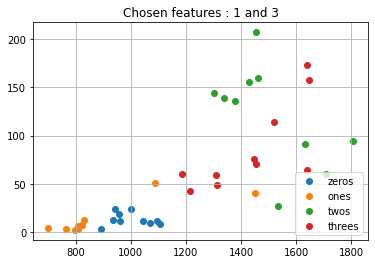

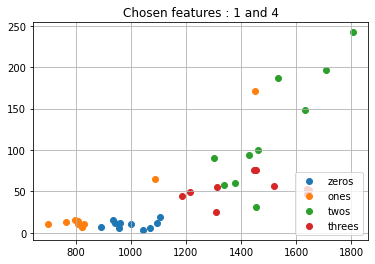

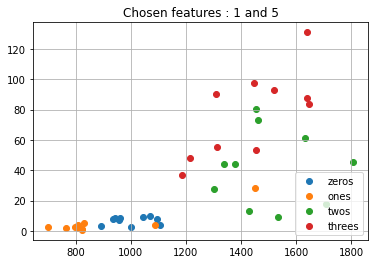

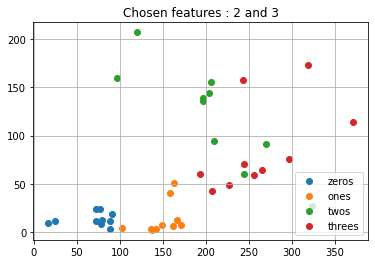

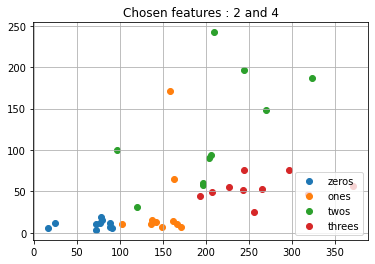

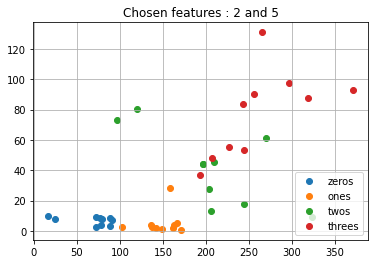

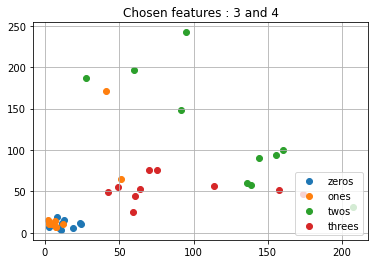

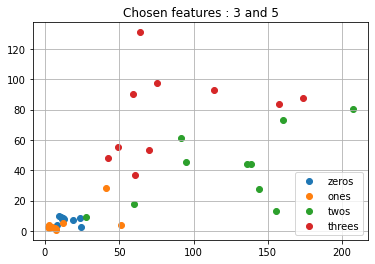

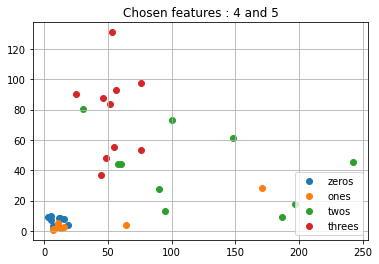

In [12]:

images = np.concatenate((zeros_im,ones_im,twos_im,threes_im))
nb_zeros=zeros_im.shape[0]
nb_ones=ones_im.shape[0]
nb_twos=twos_im.shape[0]
nb_threes=threes_im.shape[0]
number_feat=5

poss=int(special.binom((number_feat),2))
descriptors=np.zeros((nb_zeros+nb_ones+nb_twos+nb_threes,2,poss))
print(descriptors.shape)
ii=0
jj=0
for a, b in itertools.combinations(range(number_feat), 2):
    for im in images:
        cont,newimg= find_contour(im)

        contimg=np.zeros_like(im)
        contimg[cont[:,1],cont[:,0]]=255

        ''' Show the original and the contour
        fig, ax = plt.subplots(1, 2, figsize=(12, 7))
        ax[0].imshow(im,cmap='gray')
        ax[1].imshow(contimg, cmap='gray')
        plt.show()
        '''

        fourier = to_Complex(cont,transfo=False)
        feat=np.array([a,b])
        descriptors[ii,:,jj]=first_descriptors(fourier,feat)

        ii+=1
    ii=0
    jj+=1

    
# Plotting the first 2 fourier descriptors
kk=0

for a, b in itertools.combinations(range(number_feat), 2):
    fig, ax = plt.subplots(1)
    ax.scatter(descriptors[0:nb_zeros,0,kk],descriptors[0:nb_zeros,1,kk],label='zeros')
    ax.scatter(descriptors[nb_zeros:nb_zeros+nb_ones,0,kk],descriptors[nb_zeros:nb_zeros+nb_ones,1,kk],label='ones')
    ax.scatter(descriptors[nb_zeros+nb_ones:nb_zeros+nb_ones+nb_twos,0,kk],descriptors[nb_zeros+nb_ones:nb_zeros+nb_ones+nb_twos,1,kk],label='twos')
    ax.scatter(descriptors[nb_zeros+nb_ones+nb_twos:nb_zeros+nb_ones+nb_twos+nb_threes,0,kk],descriptors[nb_zeros+nb_ones+nb_twos:nb_zeros+nb_ones+nb_twos+nb_threes,1,kk],label='threes')
    ax.grid()
    plt.title('Chosen features : {} and {}'.format(a+1,b+1))
    leg=ax.legend(loc='lower right')
    kk+=1

### Discussion 

One can see that the amplitude of the first fourier descriptors do not allow to discirminate the four classes as there is no boundery between them. In order to tackle this problem one could think about other methods like PCA or a deep neural network which could capture more features that would allow to efficiently separate all each class one from another. 